In [ ]:
## reference: https://jovian.ai/k4n1shk1501/zerotogans-final-project

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 3.2 MB/s 


In [ ]:
# torch for general PyTorch functionality
import torch

# torch.nn and torch.nn.functional for neural network based functions
import torch.nn as nn
import torch.nn.functional as F

# torch.optim for our optimizer which will update the parameters of our neural network
import torch.optim as optim

# torch.utils.data for handling the dataset
import torch.utils.data as data

# torchvision.transforms for data augmentation
import torchvision.transforms as transforms

# torchvision.datasets for loading the dataset
import torchvision.datasets as datasets

# sklearn's metrics for visualizing a confusion matrix
from sklearn import metrics

# sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
from sklearn import decomposition
from sklearn import manifold

#matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
# We set the random seed for Pyton, Numpy and PyTorch to ensure we should get reproducible results
seed = 1000

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
ROOT = '.data'
train_data = datasets.MNIST(root = ROOT,train = True, download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [ ]:
# The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255
# QUESTION: WHY DO WE HAVE A NEED TO NORMALIZE DATA? 
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Mean : {mean}')
print(f'Standard Deviation : {std}')

Mean : 0.13066047430038452
Standard Deviation : 0.30810779333114624


In [ ]:
# The train transforms are to artificially create more examples for our model to train on.
# WHY DO WE DO DATA AUGMENTATION? 
train_transforms = transforms.Compose([transforms.RandomRotation(5, fill=(0,)),
                                      transforms.RandomCrop(28, padding = 2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [mean], std = [std])])
# WHY DO WE DO AUGMENTATION TO TRAIN DATA ONLY? 
# We do not augment our test data in the same way as we want a consistent set of examples to evaluate our final model.
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean = [mean], std = [std])])

In [ ]:
# We can then load the train and test data with the relevant transforms defined.
train_data = datasets.MNIST(root = ROOT, train = True, download = True, transform = train_transforms)
test_data = datasets.MNIST(root = ROOT, train = False, download = True, transform = test_transforms)
print(f'Total no of training examples : {len(train_data)}')
print(f'Total no of testing examples : {len(test_data)}')

Total no of training examples : 60000
Total no of testing examples : 10000


In [ ]:
def plot_images(images):

    no_of_images = len(images)

    rows = int(np.sqrt(no_of_images))
    cols = int(np.sqrt(no_of_images))

    fig = plt.figure()
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

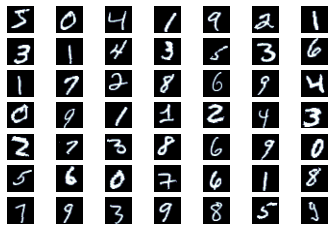

In [ ]:
# Let's look at the images that we have processed
IMAGES = 50
images = [image for image, label in [train_data[i] for i in range(IMAGES)]] 
plot_images(images)


In [ ]:
VALID_RATIO = 0.9

no_of_train_examples = int(len(train_data) * VALID_RATIO)
no_of_valid_examples = len(train_data) - no_of_train_examples

# We use the random_split fuction to take a random 10% of the training set to use as a validation set.
# The remaining 90% will stay as the training set
train_data, valid_data = data.random_split(train_data, [no_of_train_examples, no_of_valid_examples])
print(f'Total no of training examples : {len(train_data)}')
print(f'Total no  of validation examples : {len(valid_data)}')
print(f'Total no of testing examples : {len(test_data)}')

Total no of training examples : 54000
Total no  of validation examples : 6000
Total no of testing examples : 10000


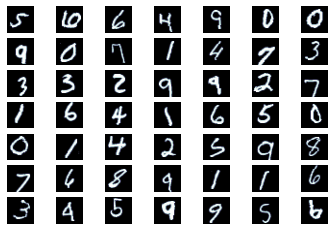

In [ ]:
# We check 50 of the images of the validation set with the training transform 
IMAGES = 50
images = [image for image, label in [valid_data[i] for i in range(IMAGES)]] 
plot_images(images)

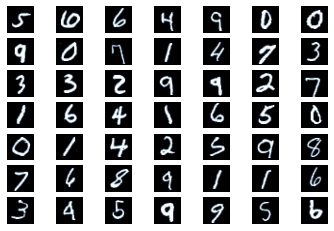

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
IMAGES = 50
images = [image for image, label in [valid_data[i] for i in range(IMAGES)]] 
plot_images(images)

In [ ]:
## Creating the Model

## Creating the Model

In [ ]:
BATCH_SIZE = 64
# WHY DATALOADER? - create batches and iterate through them
train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()         
        # Make your own MLP || LEARNING FEATUERES !! || FLATTENING AN GRAY-SCALE IMAGE AS INPUT
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Apply activation
        h_1 = F.relu(self.input_fc(x))  # self.input_fc(x)
        h_2 = F.relu(self.hidden_fc(h_1))  # self.hidden_fc(h_1)
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

In [ ]:
# We create an instance of our model and set the correct input and output dimension
INPUT_DIMENSION = 28 * 28
OUTPUT_DIMENSION = 10
model = MLP(INPUT_DIMENSION, OUTPUT_DIMENSION)

In [ ]:
# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Trainable parameters : {count_parameters(model):,}')

Trainable parameters : 222,360


In [ ]:
## Training the model

# We use Adam algorithm with the default parameters to update our model
optimizer = optim.Adam(model.parameters())

# We define a criterion, PyTorch's name for a loss/cost/error function
criterion = nn.CrossEntropyLoss()


In [ ]:
# if GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)
print(device)

cpu


In [ ]:
# Function to calculate accuracy of model
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    # Put our model in train mode
    model.train()

    # WHAT IS EPOCH? | WHAT IS ITERATION?

    # Iterate over our data loader returning batches of image,label
    for (x, y) in iterator:
        # Place the batch on our GPU, if it's available
        x = x.to(device)
        y = y.to(device)
        # Clear the gradients calculated from the last batch
        #ENTER YOUR CODE HERE
        optimizer.zero_grad()
        
        # Pass our batch of images, x, through to model to get predictions, y_pred      
        y_pred, _ = model(x)
        # Calculate the loss between our predictions and the actual labels
        loss = criterion(y_pred, y)
        # Calculate the accuracy between our predictions and the actual labels
        acc = calculate_accuracy(y_pred, y)
        # Calculate the gradients of each parameter
        # ENTER YOUR CODE HERE
        loss.backward()

        # Update the parameters by taking an optimizer step
        # ENTER YOUR CODE HERE
        optimizer.step()

        # Update our metrics
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    # We put our model into evaluation mode with model.eval()
    model.eval()
    # We do not zero gradients as we are not calculating any
    # We do not calculate gradients as we are not updating parameters
    # We do not take an optimizer step as we are not calculating gradient
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# Helper function to tell us how long an epoch took
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 5 #15

best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:  ## WHAT IS HAPPENING HERE? 
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 23s | Train Loss: 0.405 | Train Acc: 87.38% | Val. Loss: 0.151 |  Val. Acc: 95.80%
Epoch: 02 | Epoch Time: 0m 22s | Train Loss: 0.173 | Train Acc: 94.64% | Val. Loss: 0.107 |  Val. Acc: 96.69%
Epoch: 03 | Epoch Time: 0m 22s | Train Loss: 0.136 | Train Acc: 95.78% | Val. Loss: 0.088 |  Val. Acc: 97.47%
Epoch: 04 | Epoch Time: 0m 23s | Train Loss: 0.120 | Train Acc: 96.19% | Val. Loss: 0.097 |  Val. Acc: 97.18%
Epoch: 05 | Epoch Time: 0m 22s | Train Loss: 0.106 | Train Acc: 96.67% | Val. Loss: 0.096 |  Val. Acc: 97.07%


In [ ]:
## Examining the Model

# It will return the inputs (image) the outputs (model predictions) and the ground truth labels.
def get_predictions(model, iterator, device):

    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
# We make a confusion matrix from our actual labels and our predicted labels
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Reds', ax = ax)

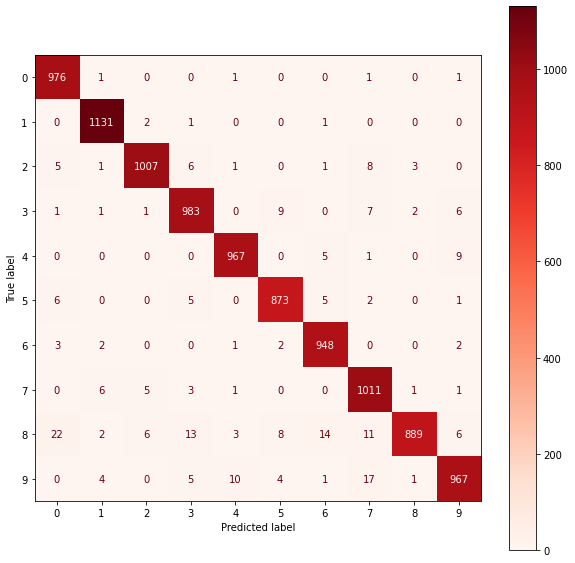

In [ ]:
plot_confusion_matrix(labels, pred_labels)
## WHAT CAN WE INFER FROM THE MATRIX?


In [ ]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_with_label(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

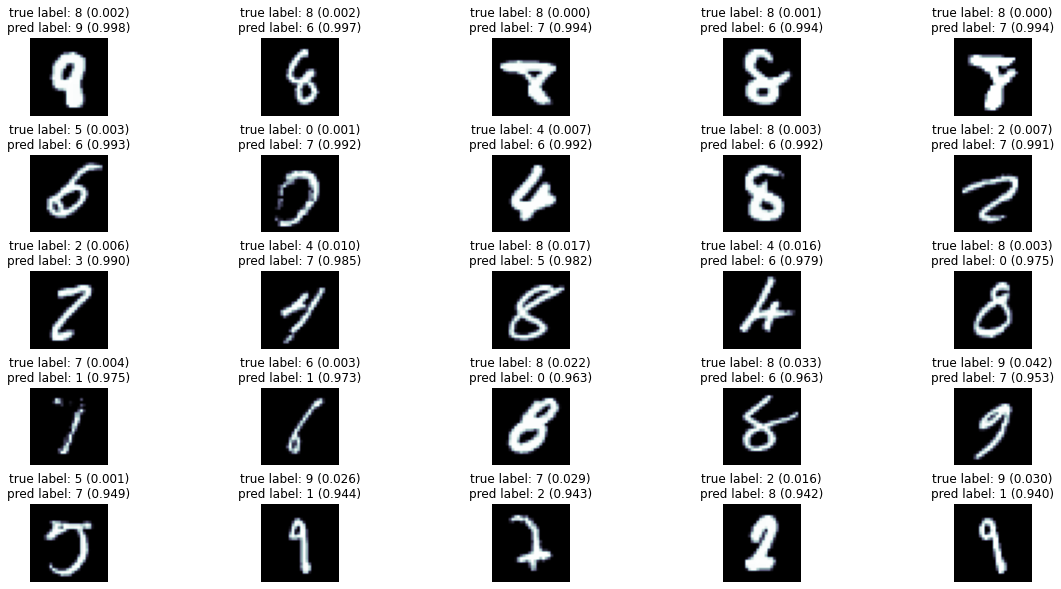

In [ ]:
## Incorrect Examples 

IMAGES = 30
plot_with_label(incorrect_examples, IMAGES)

In [ ]:
## Correct examples

correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

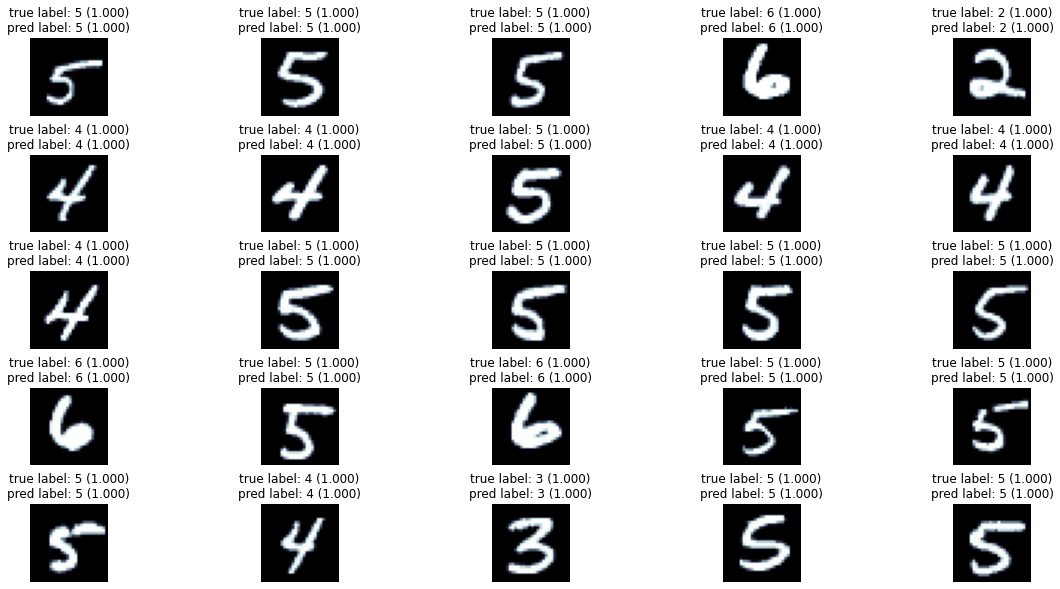

In [ ]:
IMAGES = 30
plot_with_label(correct_examples, IMAGES)